In [1]:
import os
import sys
from dotenv import load_dotenv, find_dotenv

parent_dir = os.path.abspath("./..")
sys.path.append(parent_dir)

_=load_dotenv(find_dotenv())

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
os.environ['LANGSMITH_TRACING_V2'] = 'true'
os.environ['LANGSMITH_PROJECT'] = 'deep-research'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'

# Research Agent 

*The goal of research is to gather the context requested by the research brief.*

[Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent) are well suited to research because they can flexibly apply different strategies, using intermediate results to guide their exploration.

The agent follows a [simple yet effective pattern](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent):

1. **LLM Decision Node**: Analyzes the current state and decides whether to make tool calls or provide a final response
2. **Tool Execution Node**: Executes search tools when the LLM determines more information is needed
3. **Research Compression Node**: Summarizes and compresses research findings for efficient processing
4. **Routing Logic**: Determines workflow continuation based on LLM decisions


### Prompt

First, we'll define a prompt that instructs our agent to use available search tools. 

To prevent excessive tool calls and maintain research focus, we use [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

#### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

#### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

#### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

In [2]:
from utils import show_prompt
from src.deep_research_from_scratch.prompts import research_agent_prompt
show_prompt(research_agent_prompt, "Research Agent Instructions")

╭────────────────────────────────────────── Research Agent Instructions ──────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

### State and Schemas

We'll create the agent state object.


In [ ]:
%%writefile ../src/deep_research_from_scratch/state_research.py

"""
State Definitions and Pydantic Schemas for Research Agent

This module defines the state objects and structured schemas used for
the research agent workflow, including researcher state management and output schemas.
"""

import operator
from typing_extensions import TypedDict, Annotated, List, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# ===== STATE DEFINITIONS =====

class ResearcherState(TypedDict):
    """
    State for the research agent containing message history and research metadata.
    
    This state tracks the researcher's conversation, iteration count for limiting
    tool calls, the research topic being investigated, compressed findings,
    and raw research notes for detailed analysis.
    """
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iterations: int
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]

class ResearcherOutputState(TypedDict):
    """
    Output state for the research agent containing final research results.
    
    This represents the final output of the research process with compressed
    research findings and all raw notes from the research process.
    """
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

# ===== STRUCTURED OUTPUT SCHEMAS =====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decisions during scoping phase."""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for research brief generation."""
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    summary: str = Field(description="Concise summary of the webpage content")
    key_excerpts: str = Field(description="Important quotes and excerpts from the content")

Now, we'll define our research tool.  

#### Tavily SDK Integration

We'll use the [Tavily SDK](https://docs.tavily.com/sdk/python/reference) to perform web searches.
 
####  LangChain Tools

We'll convert our Tavily search function into a [LangChain tool](https://python.langchain.com/docs/concepts/tools/) using the `@tool` decorator. This enables:
- Automatic schema generation for the LLM
- Integration with LangChain's agent framework
- Standardized tool calling interface
- Type validation and documentation

Note that some of the arguments are noted as [InjectedToolArg](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.base.InjectedToolArg.html). These are not included in the tool schema sent to the LLM, and instead are injected during execution. This gives us the flexibility to inject values at runtime, but does not burden the language model with the responsibility of managing these arguments.

In [ ]:
%%writefile ../src/deep_research_from_scratch/utils.py

"""Research Utilities and Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""

from pathlib import Path
from datetime import datetime
from typing_extensions import Annotated, List, Literal

from langchain.chat_models import init_chat_model 
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, InjectedToolArg
from tavily import TavilyClient

from src.deep_research_from_scratch.state_research import Summary
from src.deep_research_from_scratch.prompts import summarize_webpage_prompt

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def get_current_dir() -> Path:
    """Get the current directory of the module.

    This function is compatible with Jupyter notebooks and regular Python scripts.

    Returns:
        Path object representing the current directory
    """
    try:
        return Path(__file__).resolve().parent
    except NameError:  # __file__ is not defined
        return Path.cwd()

# ===== CONFIGURATION =====

summarization_model = init_chat_model(model="openai:gpt-4.1-mini")
tavily_client = TavilyClient()

# ===== SEARCH FUNCTIONS =====

def tavily_search_multiple(
    search_queries: List[str], 
    max_results: int = 3, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> List[dict]:
    """Perform search using Tavily API for multiple queries.

    Args:
        search_queries: List of search queries to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        List of search result dictionaries
    """
    
    # Execute searches sequentially. Note: yon can use AsyncTavilyClient to parallelize this step.
    search_docs = []
    for query in search_queries:
        result = tavily_client.search(
            query,
            max_results=max_results,
            include_raw_content=include_raw_content,
            topic=topic
        )
        search_docs.append(result)

    return search_docs

def summarize_webpage_content(webpage_content: str) -> str:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Formatted summary with key excerpts
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary = structured_model.invoke([
            HumanMessage(content=summarize_webpage_prompt.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        # Format summary with clear structure
        formatted_summary = (
            f"<summary>\n{summary.summary}\n</summary>\n\n"
            f"<key_excerpts>\n{summary.key_excerpts}\n</key_excerpts>"
        )
        
        return formatted_summary
        
    except Exception as e:
        print(f"Failed to summarize webpage: {str(e)}")
        return webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content

def deduplicate_search_results(search_results: List[dict]) -> dict:
    """Deduplicate search results by URL to avoid processing duplicate content.
    
    Args:
        search_results: List of search result dictionaries
        
    Returns:
        Dictionary mapping URLs to unique results
    """
    unique_results = {}
    
    for response in search_results:
        for result in response['results']:
            url = result['url']
            if url not in unique_results:
                unique_results[url] = result
    
    return unique_results

def process_search_results(unique_results: dict) -> dict:
    """Process search results by summarizing content where available.
    
    Args:
        unique_results: Dictionary of unique search results
        
    Returns:
        Dictionary of processed results with summaries
    """
    summarized_results = {}
    
    for url, result in unique_results.items():
        # Use existing content if no raw content for summarization
        if not result.get("raw_content"):
            content = result['content']
        else:
            # Summarize raw content for better processing
            content = summarize_webpage_content(result['raw_content'])
        
        summarized_results[url] = {
            'title': result['title'],
            'content': content
        }
    
    return summarized_results

def format_search_output(summarized_results: dict) -> str:
    """Format search results into a well-structured string output.
    
    Args:
        summarized_results: Dictionary of processed search results
        
    Returns:
        Formatted string of search results with clear source separation
    """
    if not summarized_results:
        return "No valid search results found. Please try different search queries or use a different search API."
    
    formatted_output = "Search results: \n\n"
    
    for i, (url, result) in enumerate(summarized_results.items(), 1):
        formatted_output += f"\n\n--- SOURCE {i}: {result['title']} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result['content']}\n\n"
        formatted_output += "-" * 80 + "\n"
    
    return formatted_output

# ===== RESEARCH TOOLS =====

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    max_results: Annotated[int, InjectedToolArg] = 3,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> str:
    """Fetch results from Tavily search API with content summarization.

    Args:
        query: A single search query to execute
        max_results: Maximum number of results to return
        topic: Topic to filter results by ('general', 'news', 'finance')
    """

    # """Fetch results from Tavily search API with content summarization.

    # Args:
    #     query: A single search query to execute
    #     max_results: Maximum number of results to return
    #     topic: Topic to filter results by ('general', 'news', 'finance')

    # Returns:
    #     Formatted string of search results with summaries
    # """

    # Execute search for single query
    search_results = tavily_search_multiple(
        [query],  # Convert single query to list for the internal function
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    )

    # Deduplicate results by URL to avoid processing duplicate content
    unique_results = deduplicate_search_results(search_results)

    # Process results with summarization
    summarized_results = process_search_results(unique_results)

    # Format output for consumption
    return format_search_output(summarized_results)

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.
    
    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.
    
    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    
    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?
    
    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps    
    """

    # """Tool for strategic reflection on research progress and decision-making.
    
    # Use this tool after each search to analyze results and plan next steps systematically.
    # This creates a deliberate pause in the research workflow for quality decision-making.
    
    # When to use:
    # - After receiving search results: What key information did I find?
    # - Before deciding next steps: Do I have enough to answer comprehensively?
    # - When assessing research gaps: What specific information am I still missing?
    # - Before concluding research: Can I provide a complete answer now?
    
    # Reflection should address:
    # 1. Analysis of current findings - What concrete information have I gathered?
    # 2. Gap assessment - What crucial information is still missing?
    # 3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    # 4. Strategic decision - Should I continue searching or provide my answer?
    
    # Args:
    #     reflection: Your detailed reflection on research progress, findings, gaps, and next steps
        
    # Returns:
    #     Confirmation that reflection was recorded for decision-making
    # """

    return f"Reflection recorded: {reflection}"


### Research Agent

#### Overview

Our research agent perform iterative tool-calling to search for information. 

The agent follows a [simple yet effective pattern](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent):

1. **LLM Decision Node**: Analyzes the current state and decides whether to make tool calls or provide a final response
2. **Tool Execution Node**: Executes search tools when the LLM determines more information is needed
3. **Research Compression Node**: Summarizes and compresses research findings for efficient processing
4. **Routing Logic**: Determines workflow continuation based on LLM decisions

#### Context Engineering Strategy

We apply **context engineering** in two places following the principles outlined in [Context Engineering for Agents](https://blog.langchain.com/context-engineering-for-agents/):

#### 1. Webpage Content Summarization
Raw search results often contain excessive noise (navigation, ads, boilerplate content). Our `summarize_webpage_content()` function:
- Uses structured output to extract key information and relevant excerpts
- Filters out irrelevant content while preserving factual details
- Compresses lengthy articles into focused summaries
- Maintains source attribution for credibility

#### 2. Research Result Compression  
As the agent performs multiple searches, the conversation context grows rapidly. Our `compress_research()` function:
- Synthesizes findings from multiple tool calls into cohesive insights
- Extracts raw notes for detailed analysis while maintaining compressed summaries
- Reduces token usage for subsequent LLM calls
- Preserves essential information for report writing

This dual-layer context engineering allows the agent to process extensive information efficiently while maintaining high-quality research output.

#### 3. Performing Careful Compression
[Compression](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) [is risky](https://cognition.ai/blog/dont-build-multi-agents)! We need to be very careful about loosing valuable information. We'll use an LLM for compression with instructions in a system prompt that comes before a potentially long, token-heavy trajectory of multiple tool calls. The long context can cause the compression LLM [to loose sight of the task instructions](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), leading to generic summaries that loose information. So, we reinforce the compression task by adding a `compress_research_human_message` that:
- Explicitly restates the original research topic at compression time
- Reminds the model to preserve ALL information relevant to the specific question
- Emphasizes that comprehensive findings are critical for final report generation
- Prevents task drift during the compression phase

#### 4. Output Token Management
Research compression can generate long outputs. We need to sure that they do not exceed model token limits, which can cause truncated responses that cut off mid-sentence (as seen with "**Sextant Coffee Ro" being cut off). As an example, [GPT-4.1 has output limit of up to 33k tokens](https://openai.com/index/gpt-4-1/) and [Claude4 sonnet supports 64k](https://www.anthropic.com/claude/sonnet). 

Model SDKs / LangChain integrations may cap this (e.g., [to `1024` tokens in the case of Claude](https://github.com/langchain-ai/langchain/blob/master/libs/partners/anthropic/langchain_anthropic/chat_models.py#L1149C5-L1149C15)). Simply ensure that max tokens is set to ensure complete output. This prevents incomplete compression outputs and ensures full research findings are preserved.

In [ ]:
%%writefile ../src/deep_research_from_scratch/research_agent.py

"""Research Agent Implementation.

This module implements a research agent that can perform iterative web searches
and synthesis to answer complex research questions.
"""

from pydantic import BaseModel, Field
from typing_extensions import Literal

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langchain.chat_models import init_chat_model

from src.deep_research_from_scratch.state_research import ResearcherState, ResearcherOutputState
from src.deep_research_from_scratch.utils import tavily_search, get_today_str, think_tool
from src.deep_research_from_scratch.prompts import research_agent_prompt, compress_research_system_prompt, compress_research_human_message

# ===== CONFIGURATION =====

# Set up tools and model binding
tools = [tavily_search, think_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize models
model = init_chat_model(model="openai:gpt-4.1") # model="anthropic:claude-sonnet-4-20250514"
model_with_tools = model.bind_tools(tools)
summarization_model = init_chat_model(model="openai:gpt-4.1-mini")
compress_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000) # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000

# ===== AGENT NODES =====

def llm_call(state: ResearcherState):
    """Analyze current state and decide on next actions.
    
    The model analyzes the current conversation state and decides whether to:
    1. Call search tools to gather more information
    2. Provide a final answer based on gathered information
    
    Returns updated state with the model's response.
    """
    return {
        "researcher_messages": [
            model_with_tools.invoke(
                [SystemMessage(content=research_agent_prompt)] + state["researcher_messages"]
            )
        ]
    }

def tool_node(state: ResearcherState):
    """Execute all tool calls from the previous LLM response.
    
    Executes all tool calls from the previous LLM responses.
    Returns updated state with tool execution results.
    """
    tool_calls = state["researcher_messages"][-1].tool_calls
 
    # Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))
            
    # Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]
    
    return {"researcher_messages": tool_outputs}

def compress_research(state: ResearcherState) -> dict:
    """Compress research findings into a concise summary.
    
    Takes all the research messages and tool outputs and creates
    a compressed summary suitable for the supervisor's decision-making.
    """
    
    system_message = compress_research_system_prompt.format(date=get_today_str())
    messages = [SystemMessage(content=system_message)] + state.get("researcher_messages", []) + [HumanMessage(content=compress_research_human_message)]
    response = compress_model.invoke(messages)
    
    # Extract raw notes from tool and AI messages
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["researcher_messages"], 
            include_types=["tool", "ai"]
        )
    ]
    
    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }


# ===== ROUTING LOGIC =====

def should_continue(state: ResearcherState) -> Literal["tool_node", "compress_research"]:
    """Determine whether to continue research or provide final answer.
    
    Determines whether the agent should continue the research loop or provide
    a final answer based on whether the LLM made tool calls.
    
    Returns:
        "tool_node": Continue to tool execution
        "compress_research": Stop and compress research
    """
    messages = state["researcher_messages"]
    last_message = messages[-1]
    
    # If the LLM makes a tool call, continue to tool execution
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we have a final answer
    return "compress_research"


# ===== GRAPH CONSTRUCTION =====

# Build the agent workflow
agent_builder = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

# Add nodes to the graph
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_node("compress_research", compress_research)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node", # Continue research loop
        "compress_research": "compress_research", # Provide final answer
    },
)
agent_builder.add_edge("tool_node", "llm_call") # Loop back for more research
agent_builder.add_edge("compress_research", END)

# Compile the agent
researcher_agent = agent_builder.compile()

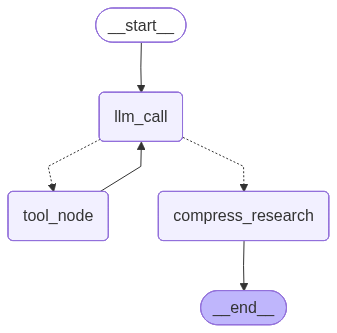

In [3]:
from IPython.display import Image, display
from src.deep_research_from_scratch.research_agent import researcher_agent

# Show the agent
display(Image(researcher_agent.get_graph(xray=True).draw_mermaid_png()))

In [4]:
# Run the agent
from utils import format_messages
from langchain_core.messages import HumanMessage

# Example brief
research_brief = """How can I develop a multi-agent application in Python using LangGraph, where sub-agents are responsible for (1)    
Retrieval-Augmented Generation (RAG), (2) querying an SQL database, and (3) performing web search, and a main agent
coordinates these sub-agents to compile all gathered information into a final report? Please include best practices
for agent design and orchestration in LangGraph, integration strategies for RAG, SQL, and web search               
functionalities, and approaches for compiling and presenting the final report. Aspects such as scalability, error  
handling, and security should be considered unless specific constraints are required. No particular sources or     
libraries beyond Python and LangGraph have been specified, so consider all relevant options within this scope.   
"""

result = researcher_agent.invoke({"researcher_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['researcher_messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ How can I develop a multi-agent application in Python using LangGraph, where sub-agents are responsible for (1) │
│ Retrieval-Augmented Generation (RAG), (2) querying an SQL database, and (3) performing web search, and a main   │
│ agent                                                                                                           │
│ coordinates these sub-agents to compile all gathered information into a final report? Please include best       │
│ practices                                                                                                       │
│ for agent design and orchestration in LangGraph, integration strategies for RAG, SQL, and web search            │
│ functionalities, and approaches for compiling and presenting the final report. Aspects such as scalability,     │
│ error                                                                                                           │
│ handling, and security should be considered unless specific constraints are required. No particular sources or  │
│ libraries beyond Python and LangGraph have been specified, so consider all relevant options within this scope.  │
│ .                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "LangGraph multi-agent system design Python best practices"                                          │
│ }                                                                                                               │
│    ID: call_lPxSQeMRxfSuAWuv6SpedJ7C                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Building Multi-Agent Systems with LangGraph: A Step-by-Step Guide ---                             │
│ URL:                                                                                                            │
│ https://medium.com/@sushmita2310/building-multi-agent-systems-with-langgraph-a-step-by-step-guide-d14088e90f72  │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ The article, authored by Sushmita Nandi and published on June 6, 2025, offers a detailed guide to building      │
│ stateful, multi-agent systems using LangGraph, an open-source framework designed to simplify creating natural   │
│ language-based workflows with large language models (LLMs). LangGraph enables developers to construct modular,  │
│ graph-structured AI workflows by defining nodes (tasks), edges (connections), and a shared state (context),     │
│ facilitating complex multi-step processes and agent collaboration beyond traditional linear chains. The guide   │
│ compares LangGraph with other frameworks like LangChain, CrewAI, AutoGen, and Google's Agent Development Kit,   │
│ highlighting LangGraph's emphasis on explicit flow control, modularity, and ease of prototyping.                │
│                                                                                                                 │
│ Key building blocks discussed include the state (shared data), nodes (functional steps), edges (workflow        │
│ control), StateGraph (workflow builder), and the @tool decorator from LangChain to expose functions as tools.   │
│ It explains types of agents supported, such as ReAct agents for dynamic tool use, chain-of-thought agents for   │
│ reasoning, and custom agents for specialized logic.                                                             │
│                                                                                                                 │
│ A practical example walks through building a LangGraph workflow comprising a ReAct search agent leveraging      │
│ Google's Gemini LLM and the Serper web search tool. This step-by-step example covers setting up API keys,       │
│ defining the search tool, agent node, state, and graph connections. The article then extends the system to a    │
│ multi-agent setup with a router agent that uses LLM-based logic to decide dynamically whether to route queries  │
│ to a search agent or a math-solving agent, demonstrating conditional branching and multi-agent collaboration.   │
│                                                                                                                 │
│ Overall, the article illustrates how LangGraph empowers building scalable, modular AI workflows that combine    │
│ multiple agents and tools with fine-grained control, encouraging experimentation and creativity in designing    │
│ intelligent applications.                                                                                       │
│ </summary>                                                                                                      │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The initial search surfaced detailed resources and practical guides on multi-agent system      │
│ design with LangGraph, best practices in agent orchestration, state management, workflow patterns, and example  │
│ architectures involving specialized sub-agents coordinated by a supervisor agent. However, these guides         │
│ primarily focus on generic tool usage, workflow structuring (e.g., Supervisor, Swarm), state management, and    │
│ debugging frameworks. Key best practices like error handling, system scalability, memory management, and        │
│ orchestration strategies are well-covered. However, there is little explicit detail in these summaries          │
│ on:\n\n1. Specific code or integration strategies for RAG, SQL querying, and web search as sub-agents in        │
│ Python.\n2. Concrete approaches for result compilation/report generation.\n3. Detailed guidance on securing     │
│ agent execution or sensitive data access within such pipelines.\n\nNext, I should search for examples or best   │
│ practices for integrating RAG, SQL/database and web search tools within LangGraph Python agents specifically,   │
│ and perhaps also for advice on secure and scalable information aggregation in such multi-agent systems."        │
│ }                                                                                                               │
│    ID: call_VWZjeyPc30mNezeb73QnxHBu                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The initial search surfaced detailed resources and practical guides on multi-agent system  │
│ design with LangGraph, best practices in agent orchestration, state management, workflow patterns, and example  │
│ architectures involving specialized sub-agents coordinated by a supervisor agent. However, these guides         │
│ primarily focus on generic tool usage, workflow structuring (e.g., Supervisor, Swarm), state management, and    │
│ debugging frameworks. Key best practices like error handling, system scalability, memory management, and        │
│ orchestration strategies are well-covered. However, there is little explicit detail in these summaries on:      │
│                                                                                                                 │
│ 1. Specific code or integration strategies for RAG, SQL querying, and web search as sub-agents in Python.       │
│ 2. Concrete approaches for result compilation/report generation.                                                │
│ 3. Detailed guidance on securing agent execution or sensitive data access within such pipelines.                │
│                                                                                                                 │
│ Next, I should search for examples or best practices for integrating RAG, SQL/database and web search tools     │
│ within LangGraph Python agents specifically, and perhaps also for advice on secure and scalable information     │
│ aggregation in such multi-agent systems.                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "LangGraph Python integration Retrieval-Augmented Generation RAG agent"                              │
│ }                                                                                                               │
│    ID: call_vjHNdDXL1Zv8D5WT02VlNOic                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "LangGraph Python SQL database agent example"                                                        │
│ }                                                                                                               │
│    ID: call_WZ36cIp6Cd4gLiiDnFBC4HYj                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "LangGraph agent web search integration tutorial"                                                    │
│ }                                                                                                               │
│    ID: call_nlnVKu6EsRCE9Qip2u3pGi6w                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Agentic RAG: From Zero to Hero with Python + LangGraph + Ollama ---                               │
│ URL: https://www.reddit.com/r/Python/comments/1op8a30/agentic_rag_from_zero_to_hero_with_python/                │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Agentic RAG refers to a Retrieval-Augmented Generation system enhanced with autonomous “agents.” Instead of     │
│ simply retrieving information                                                                                   │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Build a custom RAG agent with LangGraph - Docs by LangChain ---                                   │
│ URL: https://docs.langchain.com/oss/python/langgraph/agentic-rag                                                │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ This tutorial from LangChain Docs demonstrates how to build a custom Retrieval-Augmented Generation (RAG) agent │
│ using LangGraph primitives. The RAG agent integrates an LLM with a vector-store retriever to decide dynamically │
│ whether to retrieve context for answering a user's query or respond directly. The tutorial guides users through │
│ eight main steps: 1) Fetch and preprocess documents from Lilian Weng's blog using WebBaseLoader and             │
│ RecursiveCharacterTextSplitter; 2) Index these documents into an in-memory vector store with OpenAI embeddings  │
│ and create a retriever tool; 3) Build a node that generates queries or direct responses, binding the retriever  │
│ tool; 4) Add a grader model to evaluate the relevance of retrieved documents using structured binary outputs    │
│ ('yes' or 'no'); 5) Implement a question rewriting node to improve queries if documents are not relevant; 6)    │
│ Create an answer generation node producing concise answers from verified context; 7) Assemble these components  │
│ into a LangGraph state graph with conditional edges directing flow based on model decisions; 8) Execute and     │
│ test the complete graph with example queries, illustrating how the agent decides when to use retrieval versus   │
│ direct response. Key concepts covered include document loaders, embeddings, vector stores, LangGraph's Graph    │
│ API, state and conditional edges, and tool binding in LLM calls. The example demonstrates the agent             │
│ successfully identifying reward hacking types from blog documents, showing the power of integrating retrieval   │
│ and generation intelligently. The tutorial also referen

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Build a SQL agent - Docs by LangChain ---                                                         │
│ URL: https://docs.langchain.com/oss/python/langchain/sql-agent                                                  │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ This LangChain documentation tutorial explains how to build a SQL agent capable of answering questions about a  │
│ SQL database using LangChain's tools and agents. The agent workflow involves fetching available tables and      │
│ schemas, generating and double-checking SQL queries with a large language model (LLM), executing queries,       │
│ handling errors iteratively until successful, and formulating responses based on query results. The tutorial    │
│ uses the sample 'Chinook' SQLite database and details installation steps including LangChain, LangGraph, and    │
│ langchain-community. It covers selecting an appropriate LLM (e.g., OpenAI GPT-4.1), configuring the database    │
│ connection, and using SQLDatabaseToolkit to add tools for database interaction. The agent is created using the  │
│ create_agent function with a system prompt guiding its SQL query creation and execution process. Running the    │
│ agent on example queries demonstrates the agent's capability to autonomously generate, validate, and execute    │
│ SQL commands and respond with results. Optional usage in LangSmith Studio and human-in-the-loop review          │
│ middleware support monitoring and oversight of agent actions before query execution, enhancing safety and       │
│ control. The tutorial encourages scoped permissions for database connections to mitigate risks inherent in      │
│ model-generated SQL execution. Additionally, it references advanced customization via LangGraph primitives for  │
│ more control over SQL agent behavior.                                                                           │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ "Building Q&A systems of SQL databases requires executing model-generated SQL queries. There are inherent risks │
│ in doing this. Make sure that your database connection permissions are always scoped as narrowly as possible    │
│ for your agent’s needs.", "You MUST double check your query before executing it. If you get an error while      │
│ executing a query, rewrite the query and try again.", "Use create_agent to build a ReAct agent with minimal     │
│ code. The agent will interpret the request and generate a SQL command, which the tools will execute.", "It can  │
│ be prudent to check the agent’s SQL queries before they are executed for any unintended actions or              │
│ inefficiencies.", "LangChain agents feature support for built-in human-in-the-loop middleware to add oversight  │
│ to agent tool calls."                                  

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: AI Agents | Web Search For LLMs | LangGraph & Tavily Tutorial ---                                 │
│ URL: https://www.youtube.com/watch?v=JtQEjfzE_Ko                                                                │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ This tutorial video by M&M Tech, posted on March 28, 2025, demonstrates how to build web search tools for large │
│ language models (LLMs) and create web-powered AI agents using LangChain's Tavily integration and the LangGraph  │
│ framework. The tutorial covers obtaining a free API key from Tavily, using various search parameters (such as   │
│ topic, max results, time range, and domain filters), and creating a search tool through the langchain-tavily    │
│ package. The guide also explains how to build a web-powered AI agent by defining states, nodes, and edges in    │
│ LangGraph for interactive workflows involving an LLM and the Tavily search tool. A practical comparison shows   │
│ how a raw LLM (Claude Sonnet 3.5, June 20th, 2024 version) fails to answer a recent question about Anthropic’s  │
│ MCP protocol due to outdated training data, whereas the web-powered agent successfully retrieves updated        │
│ information by searching the web and providing a detailed, sourced answer. This approach enables up-to-date,    │
│ reliable AI responses by integrating real-time web search results with LLMs.                                    │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ Tavli search works by first getting the most accurate search results then ranking them by order of relevance    │
│ and finally feeding them back to the LLM., To get a free API key, you just need to go to the website, scroll    │
│ down to the plan section, and choose the free plan., The Tavily Documentation offers options to set topic, max  │
│ results, time range, include LLM-generated answers, image results, and domain filters., We can easily instruct  │
│ the LLM to also provide the source URL in the final answer., Our webpowered agent makes the difference by       │
│ combining real-time web search results with LLM reasoning to answer questions about recent topics that raw LLMs │
│ cannot address.                                                                                                 │
│ </key_excerpts>                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I have now found relevant technical documentation and practical tutorials for:\n1.             │
│ Implementing a Retrieval-Augmented Generation (RAG) agent with LangGraph, including tool integration,           │
│ conditional routing, context retrieval, and LLM-based decision-making (LangChain Docs, Plain English AI         │
│ article).\n2. Designing and integrating SQL agents using LangGraph, with strong emphasis on best practices like │
│ double-checking generated queries, scoped DB permissions, error handling (e.g., iterative correction,           │
│ human-in-the-loop processes), and safe database interaction (LangChain Docs).\n3. Constructing web search       │
│ agents in LangGraph using tools such as Tavily, and examples for integrating web results into LLM agent         │
│ workflows with state nodes, edge routing, and result ranking (YouTube tutorials, Analytics Vidhya, Medium       │
│ guide).\n\nWhat is still missing:\n- Explicit orchestration patterns for coordinating these three agents under  │
│ a main Supervisor/Coordinator and compiling outputs into a unified report within the LangGraph framework.\n-    │
│ More direct discussion on cross-agent state management, result aggregation/presentation, and security for       │
│ inter-agent communication, as well as any additional orchestration/HITL or fallback/error strategies when       │
│ combining these agents.\n\nNext step: Search for best practices and examples for compiling, aggregating, and    │
│ presenting multi-agent results in LangGraph, especially with a Supervisor/Main Agent architecture, and for any  │
│ advice on scalable and secure orchestration."                                                                   │
│ }                                                                                                               │
│    ID: call_8WwKQE0HG3V82C19b6YZAjzW                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I have now found relevant technical documentation and practical tutorials for:             │
│ 1. Implementing a Retrieval-Augmented Generation (RAG) agent with LangGraph, including tool integration,        │
│ conditional routing, context retrieval, and LLM-based decision-making (LangChain Docs, Plain English AI         │
│ article).                                                                                                       │
│ 2. Designing and integrating SQL agents using LangGraph, with strong emphasis on best practices like            │
│ double-checking generated queries, scoped DB permissions, error handling (e.g., iterative correction,           │
│ human-in-the-loop processes), and safe database interaction (LangChain Docs).                                   │
│ 3. Constructing web search agents in LangGraph using tools such as Tavily, and examples for integrating web     │
│ results into LLM agent workflows with state nodes, edge routing, and result ranking (YouTube tutorials,         │
│ Analytics Vidhya, Medium guide).                                                                                │
│                                                                                                                 │
│ What is still missing:                                                                                          │
│ - Explicit orchestration patterns for coordinating these three agents under a main Supervisor/Coordinator and   │
│ compiling outputs into a unified report within the LangGraph framework.                                         │
│ - More direct discussion on cross-agent state management, result aggregation/presentation, and security for     │
│ inter-agent communication, as well as any additional orchestration/HITL or fallback/error strategies when       │
│ combining these agents.                                                                                         │
│                                                                                                                 │
│ Next step: Search for best practices and examples for compiling, aggregating, and presenting multi-agent        │
│ results in LangGraph, especially with a Supervisor/Main Agent architecture, and for any advice on scalable and  │
│ secure orchestration.                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "LangGraph multi-agent orchestration supervisor aggregation compile report best practices"           │
│ }                                                                                                               │
│    ID: call_SXHqUHvakCBAkQTD9xaSqQVu                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Building a LangChain/LangGraph multi-agent orchestrator - Reddit ---                              │
│ URL: https://www.reddit.com/r/LangChain/comments/1onoufx/building_a_langchainlanggraph_multiagent/              │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ I'm trying to figure out the best practical way to manage transitions between agents (or graph nodes),          │
│ especially between an orchestrator and                                                                          │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Orchestrating Real-World Multi-Agent Workflows: Manual Wiring vs ... ---                          │
│ URL: https://www.linkedin.com/pulse/orchestrating-real-world-multi-agent-workflows-manual-nipun-david-54uuc     │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ Nipun David's LinkedIn article, published on June 26, 2025, explores orchestrating real-world multi-agent AI    │
│ workflows using LangGraph, focusing on the supervisor pattern for managing autonomous agents. The supervisor    │
│ pattern assigns a manager agent to oversee others, delegating tasks, spawning new agents dynamically,           │
│ aggregating results, and handling failures seamlessly. David contrasts two approaches: a manual wiring method,  │
│ offering fine-grained control of agent orchestration with explicit state graph management, and a modern         │
│ abstraction using LangGraph's create_supervisor function that simplifies agent registration and routing by      │
│ inferring specialties automatically. He highlights his motivation to build scalable, maintainable AI systems    │
│ capable of dynamic task delegation and routing. Key learnings include starting with manual setups for           │
│ transparency and transitioning to abstractions for scalability. The article features Python code examples       │
│ creating math and research agents, demonstrates routing logic for different query types, and discusses the      │
│ practicality of multi-agent orchestration made feasible through tools like LangGraph. David promotes LLM agents │
│ capable of reasoning and tool invocation, resembling collaborative teams, and provides links to resources for   │
│ further exploration. The post has interactive comments discussing design choices, such as exposing calculators  │
│ as tools versus agents. Overall, the article emphasizes the supervisor pattern's effectiveness for scalable,    │
│ specialized multi-agent AI systems.                    

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I found concrete architecture descriptions and patterns\u2014especially the                    │
│ Supervisor/Orchestrator\u2014in various real-world LangGraph multi-agent deployments. The Supervisor pattern is │
│ universally advocated for scalable, maintainable multi-agent orchestration. Key best practices include: (1)     │
│ supervisor/main agent delegates tasks based on input routing logic, (2) each sub-agent handles a specialized    │
│ function and returns structured outputs to the orchestrator, (3) the supervisor aggregates, synthesizes, and    │
│ presents results. Approaches to reporting include output normalization, error signaling, metadata enrichment,   │
│ and careful state management to ensure reliable report compilation. There are code examples and links to        │
│ orchestration toolkits (though not always specific to report formatting).\n\nAlso noted: advice for dynamic     │
│ agent spawning, scalability using abstractions (create_supervisor in LangGraph), error handling (monitor        │
│ health, fallback, prompt repair), and the necessity of securing communication/inter-agent data in distributed   │
│ or cloud environments. Some tips include permission scoping, human-in-the-loop (HITL) for sensitive steps, and  │
│ audit logging.\n\nAt this point, I have enough best practices and technical patterns to confidently answer how  │
│ to design the system (including reporting, orchestration, agent-node setup, and security/scalability            │
│ approaches) for Python with LangGraph. I will now prepare the complete answer, referencing integration          │
│ strategies and practical tips from gathered materials."                                                         │
│ }                                                                                                               │
│    ID: call_3AVdW2O2KszaqQakGSdc7mfi                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I found concrete architecture descriptions and patterns—especially the                     │
│ Supervisor/Orchestrator—in various real-world LangGraph multi-agent deployments. The Supervisor pattern is      │
│ universally advocated for scalable, maintainable multi-agent orchestration. Key best practices include: (1)     │
│ supervisor/main agent delegates tasks based on input routing logic, (2) each sub-agent handles a specialized    │
│ function and returns structured outputs to the orchestrator, (3) the supervisor aggregates, synthesizes, and    │
│ presents results. Approaches to reporting include output normalization, error signaling, metadata enrichment,   │
│ and careful state management to ensure reliable report compilation. There are code examples and links to        │
│ orchestration toolkits (though not always specific to report formatting).                                       │
│                                                                                                                 │
│ Also noted: advice for dynamic agent spawning, scalability using abstractions (create_supervisor in LangGraph), │
│ error handling (monitor health, fallback, prompt repair), and the necessity of securing                         │
│ communication/inter-agent data in distributed or cloud environments. Some tips include permission scoping,      │
│ human-in-the-loop (HITL) for sensitive steps, and audit logging.                                                │
│                                                                                                                 │
│ At this point, I have enough best practices and technical patterns to confidently answer how to design the      │
│ system (including reporting, orchestration, agent-node setup, and security/scalability approaches) for Python   │
│ with LangGraph. I will now prepare the complete answer, referencing integration strategies and practical tips   │
│ from gathered materials.                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here is a comprehensive guide to building a multi-agent Python application using LangGraph, with sub-agents for │
│ Retrieval-Augmented Generation (RAG), SQL querying, and web search, coordinated by a main supervisor agent for  │
│ unified report compilation. This answer incorporates best practices for agent design, system orchestration,     │
│ integration strategies for each sub-agent type, and crucial considerations for scalability, error handling, and │
│ security.                                                                                                       │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 1. Overall Architecture and Design Patterns                                                                  │
│                                                                                                                 │
│ **Supervisor Pattern:**                                                                                         │
│ - Use a Supervisor (orchestrator) agent responsible for:                                                        │
│   - Receiving the user request.                                                                                 │
│   - Delegating tasks to specialized sub-agents (RAG, SQL, Web Search).                                          │
│   - Aggregating sub-agent outputs, performing post-processing if needed.                                        │
│   - Compiling a final, structured report.                                                                       │
│ - Each sub-agent is a node (or set of nodes) in your LangGraph StateGraph, with clear, independent              │
│ responsibilities.                                                                                               │
│                                                                                                                 │
│ **State Management:**                                                                                           │
│ - Shared state (“notepad”) flows between agents, storing intermediate results and metadata, making results      │
│ accessible to the supervisor for report assembly.                                                               │
│ - Normalize sub-agent outputs to a well-defined schema for easy aggregation.                                    │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 2. Sub-Agent Implementation and Integration                                                                  │
│                                                                                                                 │
│ ### Retrieval-Augmented Generation (RAG) Agent                                                                  │
│ - Use LangGraph + LangChain primitives.                                                                         │
│ - Typical workflow:                                                                                             │
│   - Fetch and preprocess documents using loaders.                                                               │
│   - Index documents in a vector store with embeddings (e.g., OpenAI or other).                                  │
│   - Define a retriever tool for semantic document searc

In [5]:
from rich.markdown import Markdown
Markdown(result['compressed_research'])

List of Queries and Tool Calls Made                                                                                

 1 Searched for "LangGraph multi-agent system design Python best practices"                                        
 2 Searched for "LangGraph Python integration Retrieval-Augmented Generation RAG agent"                            
 3 Searched for "LangGraph Python SQL database agent example"                                                      
 4 Searched for "LangGraph agent web search integration tutorial"                                                  
 5 Searched for "LangGraph multi-agent orchestration supervisor aggregation compile report best practices"         

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Fully Comprehensive Findings                                                                                       

Building Multi-Agent Systems with LangGraph:                                                                       

 • The article offers a detailed guide to building stateful, multi-agent systems using LangGraph, an open-source   
   framework designed to simplify creating natural language-based workflows with large language models (LLMs).     
   LangGraph enables developers to construct modular, graph-structured AI workflows by defining nodes (tasks),     
   edges (connections), and a shared state (context), facilitating complex multi-step processes and agent          
   collaboration beyond traditional linear chains. The guide compares LangGraph with other frameworks like         
   LangChain, CrewAI, AutoGen, and Google's Agent Development Kit, highlighting LangGraph's emphasis on explicit   
   flow control, modularity, and ease of prototyping.                                                              
 • Key building blocks discussed include the state (shared data), nodes (functional steps), edges (workflow        
   control), StateGraph (workflow builder), and the @tool decorator from LangChain to expose functions as tools. It
   explains types of agents supported, such as ReAct agents for dynamic tool use, chain-of-thought agents for      
   reasoning, and custom agents for specialized logic.                                                             
 • A practical example walks through building a LangGraph workflow comprising a ReAct search agent leveraging      
   Google's Gemini LLM and the Serper web search tool. This step-by-step example covers setting up API keys,       
   defining the search tool, agent node, state, and graph connections. The article then extends the system to a    
   multi-agent setup with a router agent that uses LLM-based logic to decide dynamically whether to route queries  
   to a search agent or a math-solving agent, demonstrating conditional branching and multi-agent collaboration.   
 • LangGraph provides structure for multi-step LLM workflows by defining modular nodes, edges, and shared state as 
   a reusable graph. LangGraph extends LangChain by enabling stateful, multi-step workflows with branching and     
   memory. LangGraph is more structured, like a state machine with agents, compared to autonomous multi-agent      
   conversations in AutoGen. State is "a notepad your system carries around" storing shared context among nodes.   
   ReAct agents "Think, Decide, Use a tool, Reflect, Repeat," enabling dynamic tool use and step-by-step reasoning.
   "@tool decorator turns functions into tools discoverable and usable by agents," facilitating agent reasoning    
   about capabilities. Example workflow: START → router_agent → (search_agent or math_agent) → END, where router   
   uses LLM to select the proper agent based on query [1].                                                         

How to Build LangGraph Agents Hands-On Tutorial - DataCamp:                                                        

 • The DataCamp tutorial "How to Build LangGraph A

## Eval

Agents use a self-directed trajectory of tool calls to accomplish tasks.

Let's think about the ramifications of a poorly tuned tool-calling loop: 

- Early Termination: The agent decides to stop calling tools when the task is not actually complete. 
- Prolonged Looping: The agent is never satisfied with the state of its information. 

The first failure  mode results in the agent collecting insufficient information. In the deep research context, the answer may end up being too shallow. The second failure mode results in the agent utilizing an excessive number of tokens. In the deep research context, irrelevant information may poison the result.

We tuned our prompt to avoid these problems. But, let's se up a toy eval dataset that allows us to easily test agent decision-making.

In [1]:
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

# Scenario 1: Agent should CONTINUE - has insufficient/irrelevant information + think_tool realizes more research needed
messages_should_continue = [
    HumanMessage(content="What are the top coffee shops in San Francisco based on coffee quality?"),
    AIMessage(
        content="I'll search for information about top coffee shops in San Francisco focusing on coffee quality.",
        tool_calls=[
            {
                "name": "tavily_search",
                "args": {
                    "query": "coffee shops San Francisco popular locations"
                },
                "id": "call_continue_search_001",
                "type": "tool_call"
            }
        ]
    ),
    # Tavily Search provides generic cafe information - NOT focused on coffee quality
    ToolMessage(
        content="Search results show popular San Francisco cafes: Blue Bottle Coffee has great wifi and ambiance, Philz Coffee is known for custom blends and friendly service, Café Reveille has multiple locations with good pastries and laptop-friendly spaces. Ritual Coffee offers cozy seating and is popular with students.",
        tool_call_id="call_continue_search_001",
    ),
    # Agent uses think_tool to reflect and realizes the search results are insufficient
    AIMessage(
        content="Let me use the think_tool to analyze these search results and determine next steps.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of SF coffee shops. The current information is insufficient to answer the user's question about coffee quality."
                },
                "id": "call_continue_think_001",
                "type": "tool_call"
            }
        ]
    ),
    # think_tool response identifies the gap and need for more targeted research
    ToolMessage(
        content="Reflection recorded: Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of SF coffee shops. The current information is insufficient to answer the user's question about coffee quality.",
        tool_call_id="call_continue_think_001",
    )
]

# Scenario 2: Agent should STOP - has comprehensive coffee quality information + think_tool reflection
messages_should_stop = [
    HumanMessage(content="What are the top coffee shops in San Francisco based on coffee quality?"),
    AIMessage(
        content="I'll research San Francisco coffee shops specifically focusing on coffee quality assessments and expert reviews.",
        tool_calls=[
            {
                "name": "tavily_search",
                "args": {
                    "query": "best coffee quality San Francisco specialty coffee expert reviews Coffee Review ratings 2024"
                },
                "id": "call_stop_search_001", 
                "type": "tool_call"
            }
        ]
    ),
    # This ToolMessage provides COMPREHENSIVE coffee quality information - sufficient to answer the question
    ToolMessage(
        content="""Coffee quality research for San Francisco reveals top establishments based on expert reviews and specialty coffee credentials:

**Top Quality-Focused Coffee Shops:**
1. **Sightglass Coffee** - Coffee Review score 94/100, known for single-origin beans and precise roasting techniques. Featured in Bon Appétit's "Best Coffee in America" list for exceptional coffee quality.

2. **Saint Frank Coffee** - Ranked #3 coffee shop in America by The Daily Meal based on coffee quality. 4.3/5 Yelp rating with reviews specifically praising "exceptional bean quality" and "perfect extraction."

3. **Ritual Coffee Roasters** - Specialty Coffee Association member, direct trade relationships, consistently rated 4.4/5 on Google with reviews highlighting "superior coffee taste" and "expert barista skills."

4. **Blue Bottle Coffee** - Third-wave coffee pioneer, Coffee Review scores averaging 90+/100, known for rigorous quality control and fresh roasting practices.

5. **Four Barrel Coffee** - Local roaster with Coffee Review scores 88-92/100, praised by industry experts for "exceptional coffee quality" and innovative brewing methods.

**Quality Indicators Found:**
- Coffee Review professional scores (88-94/100 range)
- Specialty Coffee Association certifications
- Direct trade/single-origin sourcing
- Expert recognition from food publications
- Customer reviews specifically mentioning coffee taste and quality

This provides a comprehensive assessment of SF coffee shops based specifically on coffee quality rather than ambiance or service.""",
        tool_call_id="call_stop_search_001",
    ),
    # Agent now uses think_tool to reflect on the search results
    AIMessage(
        content="Let me reflect on the search results using the think_tool to assess whether I have sufficient information.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: I found comprehensive coffee quality information for SF coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now."
                },
                "id": "call_think_001",
                "type": "tool_call"
            }
        ]
    ),
    # think_tool response confirming reflection was recorded
    ToolMessage(
        content="Reflection recorded: Analysis of search results: I found comprehensive coffee quality information for SF coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now.",
        tool_call_id="call_think_001",
    )
]

We'll create a dataset here that has one example that should continue researching, and another example that should have all of the information necessary.

In [ ]:
import os
from langsmith import Client

langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Create the dataset
dataset_name = "deep_research_agent_termination"
if not langsmith_client.has_dataset(dataset_name=dataset_name):

    # Create the dataset
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a researcher can accurately decide to continue calling tools, or to stop.",
    )
    
    # Create the examples
    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"researcher_messages": messages_should_continue},
                "outputs": {"next_step": "continue"},
            },
            {
                "inputs": {"researcher_messages": messages_should_stop},
                "outputs": {"next_step": "stop"},
            },
        ],
    )

Here, our evaluator is simple, using a hard-coded heuristic to check if the agent correctly continues or stops.

We'll pass in the list of messages above.

We'll assess the decision made by the agent: 

* `stop` - No tool calls means the agent should stop
* `continue` - Tool calls means the agent should continue

We'll then compare this decision to the reference expected decision `next_step`.

In [ ]:
import uuid

def evaluate_next_step(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["researcher_messages"][-1].tool_calls
    made_tool_call = len(tool_calls) > 0
    return {
        "key": "correct_next_step",
        "score": made_tool_call == (reference_outputs["next_step"] == "continue")
    }

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    result = researcher_agent.nodes["llm_call"].invoke(inputs, config=config)
    return result

langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_next_step],
    experiment_prefix="Researcher Iteration",
)

We can see that in one example, the search tool doesn't return enough information, so we submit another search via tool call.

In the other example, we get all three top restaurants back, and so we decide to conclude.

One neat trick here - we were able to test a single node of our graph by calling `agent.nodes["node_name].invoke`